# Forewords
This part of the project is about learning to handle the pytorch library.
For this part I will use the MNIST dataset, found in the kaggle competition: [https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data](https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data). (I do not own the data, it is only used for educational purposes)
I will use the code of amineHY (github profile), the code is from this repository:[https://github.com/amineHY/Image-classification-of-MNIST/blob/master/pytorch_mnist_deep_cnn.ipynb](https://github.com/amineHY/Image-classification-of-MNIST/blob/master/pytorch_mnist_deep_cnn.ipynb) and a complete explanation of the code can be found here: [https://towardsdatascience.com/convolutional-neural-network-for-image-classification-with-implementation-on-python-using-pytorch](https://towardsdatascience.com/convolutional-neural-network-for-image-classification-with-implementation-on-python-using-pytorch-7b88342c9ca9). (I do not own the code, it is only used for educational purposes)


# Implementation

## Importing the libraries

In [20]:
import numpy as np # linear algebra
import struct
from array import array
from os.path import join
import random
import matplotlib.pyplot as plt
import torch as torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

### adding a seed for reproducibility
torch.manual_seed(666)

### Setting up the device

In [21]:
### setting up the device in order to use the GPU if available instead of the CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Data acquisition and data preprocessing

### Functions from kaggle to read and convert ubyte files into arrays + a function to display the images

In [22]:
### MNIST LOADER CLASS
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

### Helper function to display a list of randomly chosen images and their labels
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

### Loading the data and displaying some images

In [23]:
input_paths = './Data/archive/'
training_images_filepath = join(input_paths, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_paths, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_paths, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_paths, 't10k-labels.idx1-ubyte')


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                   test_images_filepath, test_labels_filepath)
(train_im, train_lab), (test_im, test_label) = mnist_dataloader.load_data()

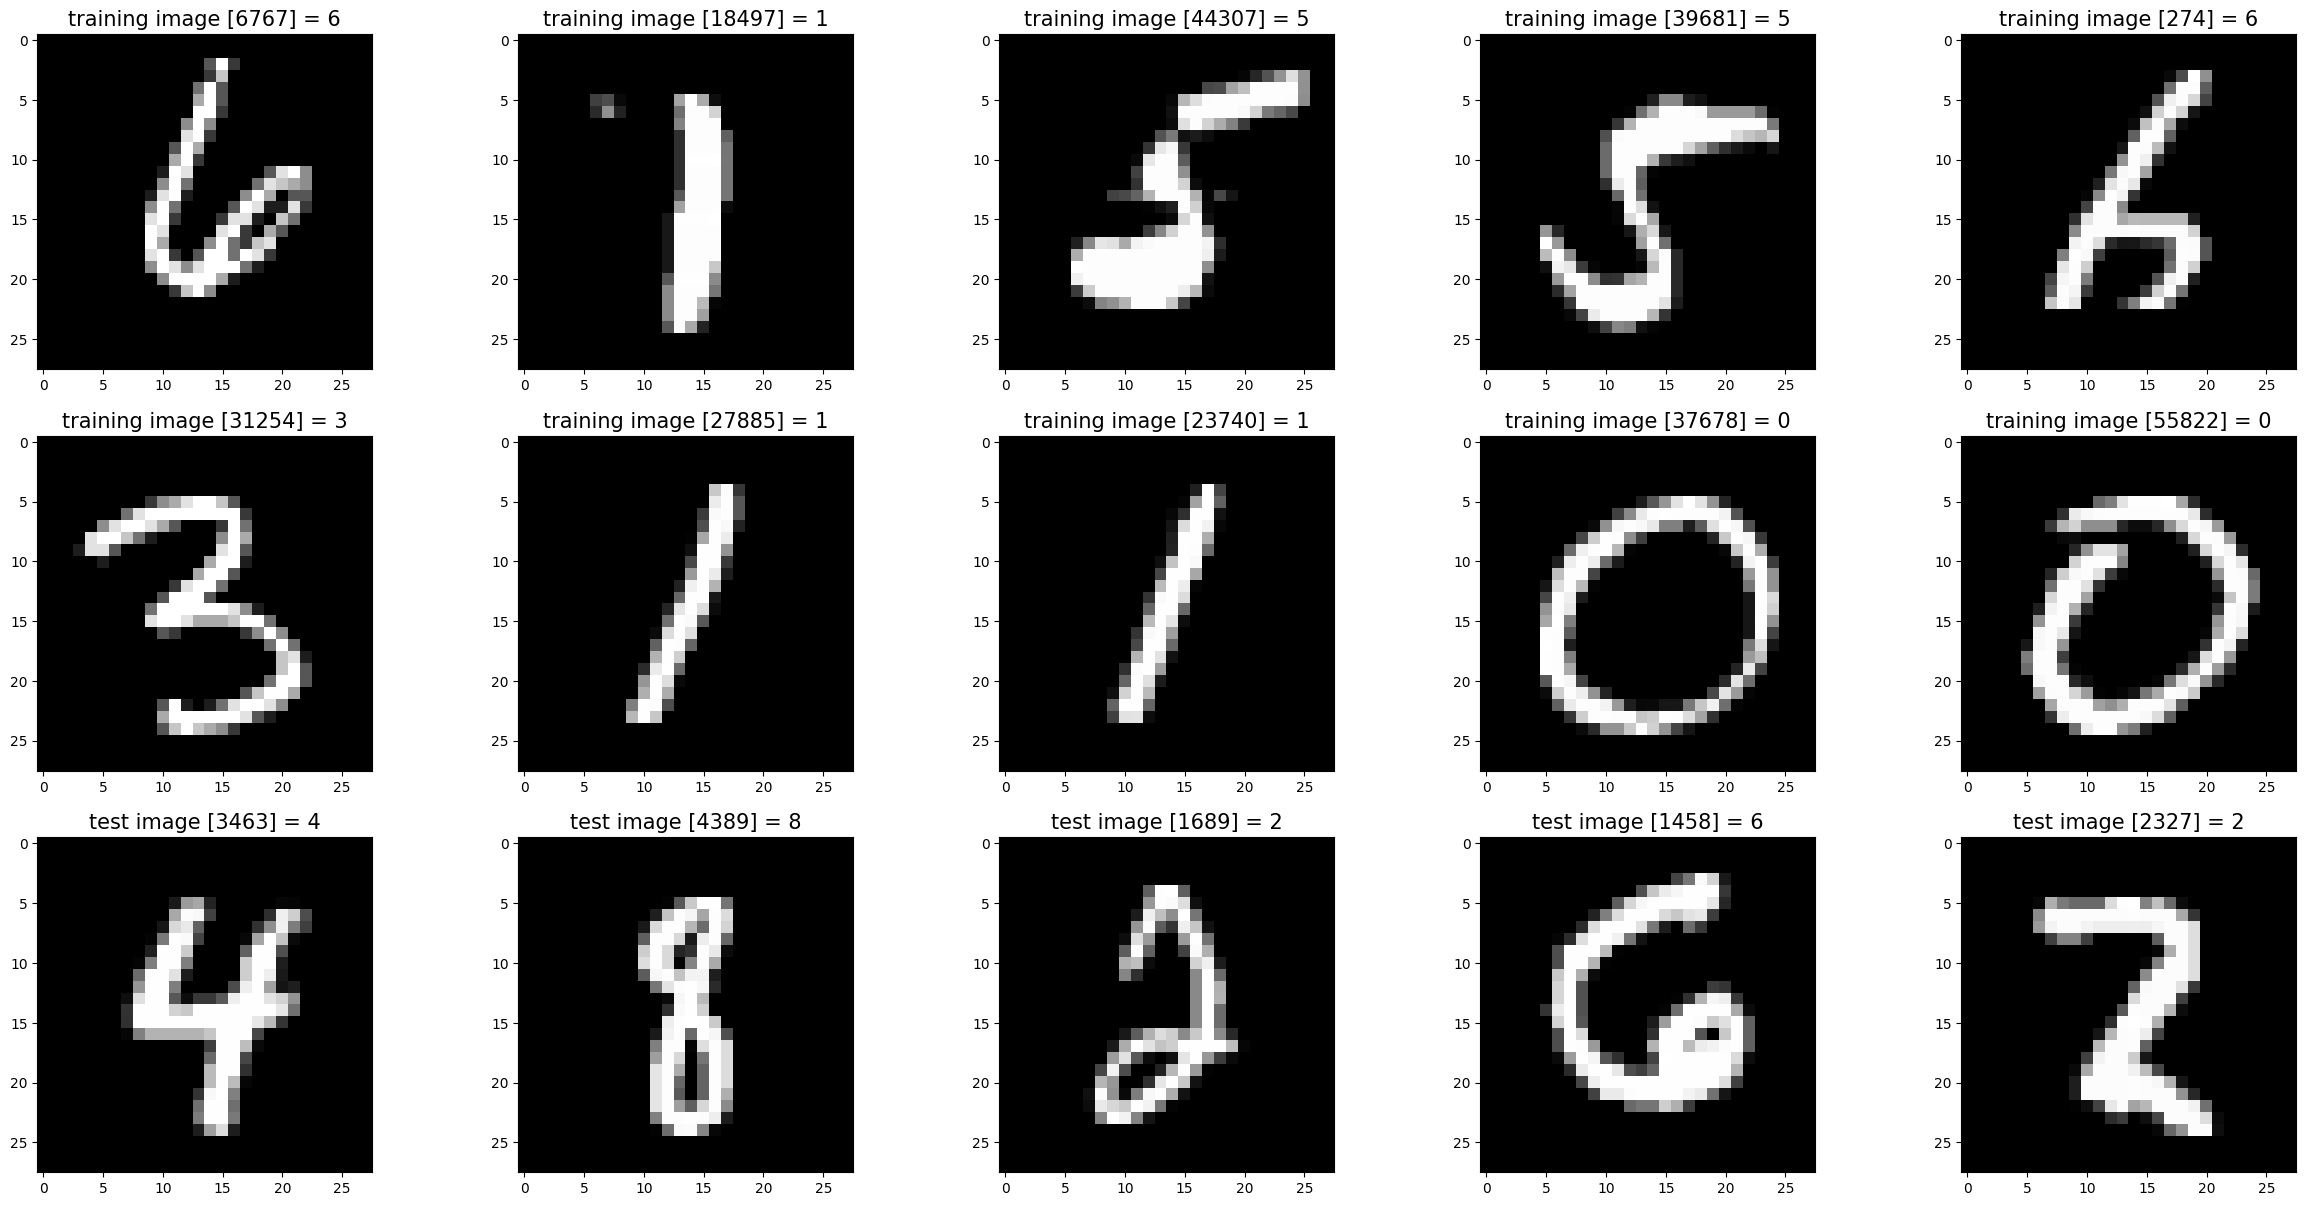

In [24]:
### showing some images
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_im[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_lab[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_im[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(test_label[r]))

show_images(images_2_show, titles_2_show)

### Data Preprocessing (dataset, dataloader creation)

In [25]:
### class to create the dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        ### we use torch.tensor instead of the from_numpy method in order to avoid modifying the original data
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __head__(self):
        return self.x.head(), self.y.head()



In [26]:
(train_im, train_lab), (test_im, test_label) = mnist_dataloader.load_data() ## reloading the data to make sure we have the original data without any alteration

train_im = np.array(train_im)
train_label = np.array(train_lab)
test_im = np.array(test_im)
test_label = np.array(test_label)



In [27]:
df = MyDataset(train_im, train_label)
data_loader = DataLoader(df, batch_size=32, shuffle=True)

AttributeError: 'MyDataset' object has no attribute 'shape'

## Building the model

In [43]:
keep_prob = 1
class CNN(torch.nn.Module): ## this allows to create a much deeper neural net with dedicated layers and theirs "sub layers"
    ### in some sense a self.layer is a set of multiple layer that need to work together as a whole pipeline
    """
    init serves to create the different layers of the mode but it is not already wired,
    the forward function is the one that will wire the layers together
    """
    def __init__(self):
        super(CNN, self).__init__() ### really important to call the mother class cosntructor (Module)
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential( ### first pipeline to
            ## following line is the convolutional layer which filters out the essential patterns (image processing)
            ## in some sense we do a pattern extraction
            ## (white tiles do not serve at all at the borders of the image for example)
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),

            ## output of the layer is a set of feature maps that represent the presence of learned features in different spatial locations.
            torch.nn.ReLU(), ### simple activation function
            ### allows the downsizing of the initial image => decreases the complexity
            torch.nn.MaxPool2d(kernel_size=2, stride=2), ## kernel size of 2 is generally good (gives good results)
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### instantiating the model
model = CNN()
model

/var/folders/_b/mvxt480d0h5202lsn8_qnpx80000gn/T/ipykernel_6078/2377706635.py:43: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [44]:
for param in model.parameters():
    print(param.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([625, 2048])
torch.Size([625])
torch.Size([10, 625])
torch.Size([10])


### Loss function and optimizer

In [45]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params= model.parameters(), lr=learning_rate)

## Training phase

In [49]:
print('Training the model')

train_cost = []
train_accu = []

training_epochs = 15

total_batch = len(data_loader)

print('Training set size: {}'.format(len(df)))
print('Testing set size: {}'.format(len(test_im)))
print('Batch size: {}'.format(len(data_loader)))
print('Total number of batches: {}'.format(total_batch))
print('Number of epochs: {}'.format(training_epochs))

for epochs in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device)
        print(X.shape)
#         Ytr = batch_Y.to(device)
#
#         optimizer.zero_grad()
#
#         Yhat = model(X)
#         cost = criterion(Yhat, Ytr)
#
#         cost.backward()
#         optimizer.step()
#
#         pred = Yhat.data.max(dim = 1)[1]
#         train_accu.append(((pred.data == Ytr.data).float().mean()).item())
#         train_cost.append(cost.item())
#         if i % 200 == 0:
#             print('Epoch: {}/{}, Batch: {}/{}, Cost: {:.4f}, Accuracy: {:.4f}'.format(epochs + 1, training_epochs, i + 1, total_batch, cost.item(), train_accu[-1]))
#
#         avg_cost += cost.data / total_batch
#     print('Epoch: {}/{}, Cost: {:.4f}'.format(epochs + 1, training_epochs, avg_cost))
# print('Learning Finished!')

Training the model
Training set size: 60000
Testing set size: 10000
Batch size: 1875
Total number of batches: 1875
Number of epochs: 15
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32, 28, 28])
torch.Size([32

60000


## Testing phase